In [1]:
import ecc_tools as tools
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#import emachine as EM
from direct_info import direct_info

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

tools.hide_toggle()

# Compare DCA and ER Sensitivity
* ER does better than traditional methods with small sample size
* Want to analyse a Protein family with large number of sequences to test sensitivity
    * DCA paper uses PF00071 and PF04542

## PF04542

#### Read In Protein Structure

In [2]:
# Read in Protein structure
data_path = '../Pfam-A.full'
pfam_id = 'PF04542'
pfam_id = 'PF00186'
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))

# Pre-Process Structure Data
# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Print PDB array 
print(pdb)
print(pdb[0])

# Create pandas dataframe for protein structure
df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
df.head()

ipdb = 0
print('seq:',int(pdb[ipdb,1]))

from data_processing import data_processing
# data processing
s0,cols_removed = data_processing(data_path,pfam_id,ipdb,\
                gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)

print("Removed columns: ",cols_removed)

tools.hide_toggle()

number of pdb structures: 372
[['PF00186' '69' 'Q5KZ26_GEOKA' ... 'B' '1' '160']
 ['PF00186' '69' 'Q5KZ26_GEOKA' ... 'A' '1' '160']
 ['PF00186' '83' 'Q81R22_BACAN' ... 'B' '2' '160']
 ...
 ['PF00186' '6952' 'DYR_MYCTU' ... 'A' '1' '158']
 ['PF00186' '7457' 'Q834R2_ENTFA' ... 'A' '1' '161']
 ['PF00186' '7457' 'Q834R2_ENTFA' ... 'A' '1' '161']]
['PF00186' '69' 'Q5KZ26_GEOKA' '1' '160' '1ZDR' 'B' '1' '160']
seq: 69
shape of s (import from msa.npy):
 (7750, 918)
shape of s (after UTF-8 decode):
 (7750, 918)
pdb:
 [[b'PF00186' b'69' b'Q5KZ26_GEOKA' ... b'B' b'1' b'160']
 [b'PF00186' b'69' b'Q5KZ26_GEOKA' ... b'A' b'1' b'160']
 [b'PF00186' b'83' b'Q81R22_BACAN' ... b'B' b'2' b'160']
 ...
 [b'PF00186' b'6952' b'DYR_MYCTU' ... b'A' b'1' b'158']
 [b'PF00186' b'7457' b'Q834R2_ENTFA' ... b'A' b'1' b'161']
 [b'PF00186' b'7457' b'Q834R2_ENTFA' ... b'A' b'1' b'161']]
pdb (after UTF-8 decode, removing 'b'):
 [['PF00186' '69' 'Q5KZ26_GEOKA' ... 'B' '1' '160']
 ['PF00186' '69' 'Q5KZ26_GEOKA' ... 'A' '1

#### Process Protein Data
* Want to implement some changes to original code
    * Enforce AA distance requirement &rightarrow; |i-j|>5

In [3]:
ipdb = 0
print('seq:',int(pdb[ipdb,1]))

# data processing
s0,cols_removed = data_processing(data_path,pfam_id,ipdb,\
                gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)

tools.hide_toggle()

seq: 69
shape of s (import from msa.npy):
 (7750, 918)
shape of s (after UTF-8 decode):
 (7750, 918)
pdb:
 [[b'PF00186' b'69' b'Q5KZ26_GEOKA' ... b'B' b'1' b'160']
 [b'PF00186' b'69' b'Q5KZ26_GEOKA' ... b'A' b'1' b'160']
 [b'PF00186' b'83' b'Q81R22_BACAN' ... b'B' b'2' b'160']
 ...
 [b'PF00186' b'6952' b'DYR_MYCTU' ... b'A' b'1' b'158']
 [b'PF00186' b'7457' b'Q834R2_ENTFA' ... b'A' b'1' b'161']
 [b'PF00186' b'7457' b'Q834R2_ENTFA' ... b'A' b'1' b'161']]
pdb (after UTF-8 decode, removing 'b'):
 [['PF00186' '69' 'Q5KZ26_GEOKA' ... 'B' '1' '160']
 ['PF00186' '69' 'Q5KZ26_GEOKA' ... 'A' '1' '160']
 ['PF00186' '83' 'Q81R22_BACAN' ... 'B' '2' '160']
 ...
 ['PF00186' '6952' 'DYR_MYCTU' ... 'A' '1' '158']
 ['PF00186' '7457' 'Q834R2_ENTFA' ... 'A' '1' '161']
 ['PF00186' '7457' 'Q834R2_ENTFA' ... 'A' '1' '161']]
#

-------------------------Remove Gaps--------------------------#
s[tpdb] shape is  (918,)
s = 
 [['-' '-' '-' ... '-' '-' '-']
 ['-' '-' '-' ... '-' '-' '-']
 ['-' '-' '-' ... '-' '-' 

In [4]:
# number of positions
n_var = s0.shape[1]
print("Number of residue positions:",n_var)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 
print("(Sanity Check) Column indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
print("(Sanity Check) Column indices of second and (",i1i2[1],") and second to last (",i1i2[-2],") positions")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

tools.hide_toggle()

Number of residue positions: 137
Number of different amino acids at each position [ 6 16 12  7  8 16  8 17 12 14  9 19 11 10 13  5  5 14  9  6 11  2  9 12
 11  9 10 16 17 11 12 13  5  4  9  7 11  6  5 10 12 10  9  9 17  8  8  2
  5  2 11 11 18 18 20 20 20 14 13 15 16 15 14 14  7 12 15 12  8 15 15 21
 19 16 16 20 15 17 13 11  8 10 12 13  4  3 13 15 12 11 13 19  9 11 17  7
 14  8 16  3 16 19 15 14 15  7  7 15  7 17 10 16 20 17 18  5 17 16 17 20
 19 18 21 21 19 15 17 13 16 13 14 10 14  9 18 14  5]
(Sanity Check) Column indices of first and ( [0 6] ) and last ( [1697 1702] ) positions
(Sanity Check) Column indices of second and ( [ 6 22] ) and second to last ( [1683 1697] ) positions
Total number of variables 1702


#### Generate OneHot Encoded Sequence (s0 &rightarrow; s)

In [5]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)
#print("Amino Acid sequence Matrix\n",s0)
#print("OneHot sequence Matrix\n",s)
#print("An individual element of the OneHot sequence Matrix (size:",
#      s.shape,") --> ",s[0], " has length ",s[0].shape)

tools.hide_toggle()

#### Use Expectation Reflection to infer w, and H
* I want to start saving these files to read in (save on computation time)

In [7]:
# Stop long code run
#assert False

# Define wight matrix with variable for each possible amino acid at each sequence position
w = np.zeros((mx.sum(),mx.sum())) 
h0 = np.zeros(mx.sum())

# Expectation Reflection
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

#-------------------------------
# parallel
start_time = timeit.default_timer()
#res = Parallel(n_jobs = 4)(delayed(predict_w)\
#res = Parallel(n_jobs = 8)(delayed(predict_w)\
res = Parallel(n_jobs = 32)(delayed(predict_w)\
        (s,i0,i1i2,niter_max=10,l2=100.0)\
        for i0 in range(n_var))

run_time = timeit.default_timer() - start_time
print('run time:',run_time)
#----------------niter_max,l2)
for i0 in range(n_var):
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    h01 = res[i0][0]
    w1 = res[i0][1]

    h0[i1:i2] = h01
    w[:i1,i1:i2] = w1[:i1,:]
    w[i2:,i1:i2] = w1[i1:,:]

# make w symmetric
w = (w + w.T)/2.

# Calculate Direct Information from infered weights and Original Sequence Data
di = direct_info(s0,w)

# Save w and di for future use
np.save('ER_w.npy',w)
np.save('ER_DI.npy',di)

tools.hide_toggle()

/home/eclay/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


run time: 107.90672698100025


#### Calculate Direct Information and Plot against Contact Map

Structure exists: '/home/eclay/DCA_ER/zd/pdb1zdr.ent' 


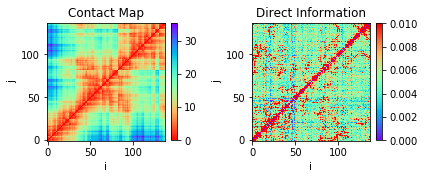

In [8]:
ct = tools.contact_map(pdb,ipdb,cols_removed)

# Calculate Direct Information from infered weights and Original Sequence Data
di = direct_info(s0,w)

# Plot Contact Map and Direct Information 
plt.subplot2grid((1,2),(0,0))
plt.title('Contact Map')
plt.imshow(ct,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045,pad=0.05)

plt.subplot2grid((1,2),(0,1))
plt.title('Direct Information')
plt.imshow(di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.show()

tools.hide_toggle()